In [1]:
# No caso de classificação binária isso também ocorre, mas como é possível determinar a probabilidade da primeira classe sabendo a probabilidade da primeira (já que  é por isso que costumamos trabalhar apenas com a segunda componente desse vetor selecionando `probs[:, 1]`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [3]:
def plot_simplex(ax_3d):
    p1 = np.linspace(-1, 1.1, 221)
    p2 = np.linspace(-1, 1.1, 221)
    P1, P2 = np.meshgrid(p1, p2)
    P3 = 1 - P1 - P2

    mask_simplex = (np.isclose(P1 + P2 + P3, 1) & (P1 >= 0)  & (P2 >= 0)  & (P3 >= 0))
    ax_3d.plot_trisurf(P1[mask_simplex], P2[mask_simplex], P3[mask_simplex], color='k', alpha=0.25)

In [4]:
# https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
# https://matplotlib.org/3.5.0/tutorials/toolkits/mplot3d.html#mpl_toolkits.mplot3d.Axes3D.plot_trisurf

def plot_3d_regions(fited_nn, ax_3d):
    p1 = np.linspace(-1, 1.1, 221)
    p2 = np.linspace(-1, 1.1, 221)
    P1, P2 = np.meshgrid(p1, p2)
    P3 = 1 - P1 - P2

    mask_simplex = (np.isclose(P1 + P2 + P3, 1) & (P1 >= 0)  & (P2 >= 0)  & (P3 >= 0))
    
    P1, P2, P3 = P1[mask_simplex], P2[mask_simplex], P3[mask_simplex]
    
    _, ind = fited_nn.kneighbors(np.vstack([np.ravel(P1), np.ravel(P2), np.ravel(P3)]).T)
    
    mask0, mask1, mask2 = ind[:, 0] == 0, ind[:, 0] == 1, ind[:, 0] == 2
    
    for mask_, c in zip([mask0, mask1, mask2], ['r', 'b', 'g']):
        ax_3d.plot_trisurf(P1[mask_], P2[mask_], P3[mask_], color=c, alpha=0.25)

In [5]:
def config_ax(ax):
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    
    ax.tick_params(axis='both', which='major', pad=-4)
    ticks = np.linspace(0, 1, 5)
    ticks_str = list(map(lambda x: str(x) if x not in [0, 1] else str(int(x)), np.linspace(0, 1, 5)))
    fontsize = 6
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_str, fontsize=fontsize)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks_str, fontsize=fontsize)
    ax.set_zticks(ticks)
    ax.set_zticklabels(['0', '', '', '', '1'], fontsize=fontsize)
    
    ax.set_xlabel('Class 0 prob', labelpad=-8)
    ax.set_ylabel('Class 1 prob', labelpad=-8)
    ax.set_zlabel('Class 2 prob', labelpad=-12)
    
    ax.view_init(elev=45, azim=45, roll=0)
    
    return ax

In [6]:
# make_classification(n_samples=1000, n_informative=6, n_classes=3, weights=(0.5, 0.4, 0.1), random_state=42)

from sklearn.datasets import fetch_openml

def make_n_classes(n, y):
    dic = dict(zip(y.value_counts().head(n-1).index, range(n-1)))
    return np.array(list(map(lambda x: dic.get(x, n-1), y)))

def read_dataset():
    X, y_original = fetch_openml(
        data_id=4541, parser='auto', return_X_y=True, as_frame=True
    )
    y = make_n_classes(3, y_original)
    X = X.drop(columns=['encounter_id', 'patient_nbr'])
    return X, y

___

Para ilustrar a discussão de otimização de threshold no caso multiclasse usaremos o [`sklearn.datasets.fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) com `data_id=4541` e o tornaremos um dataset com três classes, mas, como veremos adiante, a estratégia é genérica para qualquer número de classes. A escolha de 3 foi apenas para uma melhor visualização.

In [7]:
X, y = read_dataset()

X_train_model, X_test, y_train_model, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train_model, X_train_threshold, y_train_model, y_train_threshold = \
train_test_split(X_train_model, y_train_model, test_size=0.2, random_state=0, stratify=y_train_model)

Em um problema de classificação multiclasse (com `n` classes), o output "probabilístico" de um típico classificador do scikit-learn será um vetor com `.shape` de `(n_samples, n)`. Para cada exemplo esse vetor de `n` componentes nos dá a "probabilidade" de cada exemplo pertencer a classe associada àquele índice. Ou seja, a primeira componente é a probabilidade dos exemplos pertencerem à primeira classe, a segunda componente as probabilidades da segunda classe e assim por diante.

In [8]:
model = LGBMClassifier(random_state=42).fit(X_train_model, y_train_model)

probs = model.predict_proba(X_train_threshold)
preds = model.predict(X_train_threshold)

print(f"Number of samples in X_train_threshold: {X_train_threshold.shape[0]}.",
      f"Number of classes: {len(np.unique(y))}.",
      f"\nprobs.shape: {probs.shape}.")

Number of samples in X_train_threshold: 15265. Number of classes: 3. 
probs.shape: (15265, 3).


Por representar uma probabilidade, esse vetor é tal que suas linhas sempre somam 1, ou seja, a probabilidade de uma amostrar estar em uma das classes é 1.

In [9]:
(np.isclose(probs.sum(axis=1), 1)).all()

True

O espaço de vetores de `n` dimensões tal que suas componentes somam 1 é chamado de simplex do $\mathbb{R}^n$. No caso em que o número de classes é 2, então o simplex se torna simplesmente uma linha que vai do ponto $(1, 0)$ ao ponto $(0, 1)$ e pode ser parametrizado diretamente pela probabilidade de uma das classes, por exemplo como $\left\{ (1-p, p) : p \in [0, 1] \right\}$. Essa simplificação é o motivo para as métricas de classificação binária de bibliotecas famosas de aprendizado de máquina como o scikit-learn pedirem para você passar apenas a probabilidade da segunda classe para suas funções que calculam essas métricas fazendo `roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])`.


Essa simplificação do simplex de dimensão 2 para uma linha permite que você escolha thresholds de maneira razoavelmente simples para transformar o output probabilístico do modelo em previsões duras (ou seja, escolhendo apenas uma das classes).

Já discutimos, em um [post anterior sobre otimização de hiperparâmetros para métricas dependentes de threshold](https://vitaliset.github.io/threshold-dependent-opt/) um pouco sobre uma estratégia possível para executar essa transformação:

- Defina uma métrica de interesse que você deseja otimizar com o processo de definição de threshold;
- Selecione vários valores diferentes de threshold $t \in (0, 1)$ tais que o seu novo predict será da forma "if `.predict_proba > t`, then predict `1`; otherwise, predict `0`. Em geral você pode fazer um grid simples usando o [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html);
- Calcule sua métrica com cada possível valor de `t` do seu grid de valores e escolha o melhor valor de threshold (de acordo com algum critério - por exemplo, o threshold que explicitamente deu o melhor valor da sua métrica de interesse).

Isso funciona bem para o caso binário, mas não é imediato extender essa ideia para o caso de três classes e muito menos para um caso genérico em que temos `n` classes. Por exemplo, para três classes, o simplex que antes era uma linha, se torna um triângulo, um objeto um pouco mais complexo de se dividir.

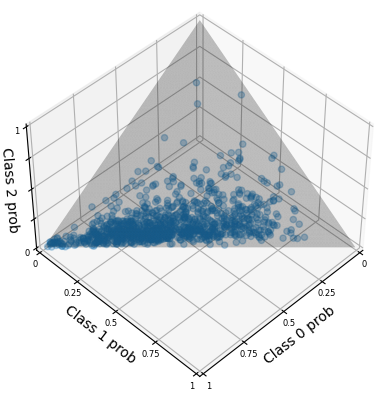

In [10]:
plot_sample = np.random.RandomState(42).choice(len(probs), 1000, replace=False)

ax = plt.figure().add_subplot(projection='3d')

config_ax(ax)
ax.scatter(probs[plot_sample, 0], probs[plot_sample, 1], zs=probs[plot_sample, 2], alpha=0.3)
plot_simplex(ax)
plt.show()

Não é imediato pensar em como parametrizar a divisão desse objeto em três regiões, diferente da trivial divisão do simplex de dimensão dois onde definir o `t` bastava para uma região ficar sendo prevista como um valor e a outra região com outra.

A ideia desse post é tentar atacar esse problema, de uma forma genérica o suficiente para ser aplicável em problemas com um número `n` de classes qualquer.

___

## Entendendo o predict usual

In scikit-learn, the implementation of `.predict`, in general, follows the logic [implemented](https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/ensemble/_forest.py#L800-L837) for [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):
```python
def predict(self, X):
    ...
    proba = self.predict_proba(X)
    ...
    return self.classes_.take(np.argmax(proba, axis=1), axis=0)
```

Isso significa que dado um vetor no simplex, o valor previsto é o da componente tal que ele é maior. Isso na verdade é equivalente a encontrar qual o vértice mais perto daquele ponto do simplex.

**Teorema**: Seja um vetor $\textbf{p} = (p_1, p_2, p_3)$ no simplex de $\mathbb{R}^3$, então $p_1$ é o maior elemento de $\textbf{p}$ se e somente se $\textbf{p}$ está mais próximo (no sentido de distância euclidiana) do ponto $(1, 0, 0)$ do que dos pontos $(0, 1, 0)$ e $(0, 0, 1)$.

**Demonstração**: ... Olhar o markedown do Distancias o layout disso...

Isso não acontece apenas para o indice 1, mas para todos .......

Podemos verificar tal fato no nosso exemplo utilizando um [`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) e verificando que o índice do vizinhos mais próximo de fato coincidem com o valor que o nosso `.predict` nos retornou anteriormente.

In [11]:
edges_of_simplex = np.identity(3)
edges_of_simplex

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [12]:
nn = NearestNeighbors(n_neighbors=1, p=2).fit(edges_of_simplex)
_, ind = nn.kneighbors(probs)

(ind[:, 0] == preds).all()

True

Vendo tal fato visualmente, temos que o diagrama de Voronoi das quinas quebra o simplex nas regiões definidas pelo `.argmax`.

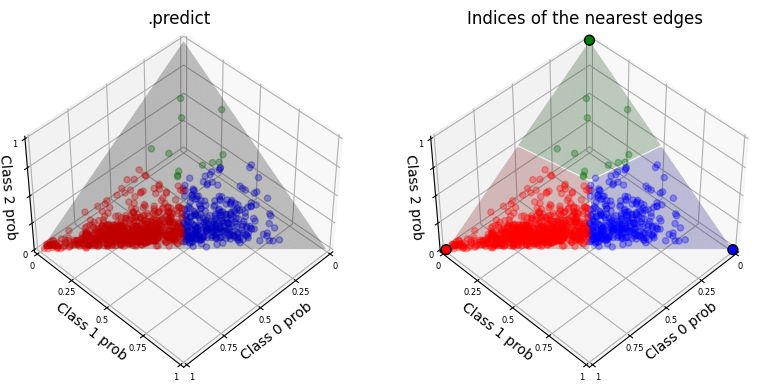

In [13]:
color_dic = dict(zip(range(3), ['r', 'b', 'g']))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')

for axis in ax:
    config_ax(axis)

color_list_preds = list(map(lambda x: color_dic[x], preds[plot_sample]))
ax[0].scatter(probs[plot_sample, 0], probs[plot_sample, 1], zs=probs[plot_sample, 2], c=color_list_preds, alpha=0.3)
ax[0].set_title(".predict")
plot_simplex(ax[0])

color_list_nn = list(map(lambda x: color_dic[x], ind[plot_sample, 0]))
ax[1].scatter(probs[plot_sample, 0], probs[plot_sample, 1], zs=probs[plot_sample, 2], c=color_list_nn, alpha=0.3)
ax[1].scatter(edges_of_simplex[:, 0], edges_of_simplex[:, 1], zs=edges_of_simplex[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
ax[1].set_title("Indices of the nearest edges")
plot_3d_regions(nn, ax[1])

plt.show()

Isso não acontece apenas no caso de dimensão 3 e é possível generalizar o nosso teorema para qualquer número de dimensões. Aqui, vamos ver isso acontecendo computacionamente da mesma forma que testamos no caso de três classes.

In [14]:
from sklearn.ensemble import RandomForestClassifier

for N_CLASSES in tqdm(range(2, 11)):
    X_n_classes, y_n_classes = make_classification(
        n_samples=1000, n_features=30, n_informative=22, n_classes=N_CLASSES, random_state=42
    )

    model_n_classes = RandomForestClassifier(max_depth=4, random_state=42).fit(X_n_classes, y_n_classes)

    probs_n_classes = model_n_classes.predict_proba(X_n_classes)
    preds_n_classes = model_n_classes.predict(X_n_classes)

    edges_of_simplex_n_classes = np.identity(N_CLASSES)

    nn_n_classes = NearestNeighbors(n_neighbors=1).fit(edges_of_simplex_n_classes)

    _, ind_n_classes = nn_n_classes.kneighbors(probs_n_classes)
    assert (ind_n_classes[:, 0] == preds_n_classes).all()

100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Essa percepção nos permite tentar extender essa ideia: e se movermos o que estávamos chamando de quinas para outros pontos do meu simplex e construir o diagrama de Voronoi com esses novos centróides?

## Definindo novos centroídes do diagrama de Voronoi

Podemos sortear pontos aleatórios do nosso simplex para serem nossos novos candidatos a "quinas". Esses novos pontos definem diagramas de influência (Voronoi) diferentes dos iniciais em que os centroides eram os do tipo `centroides_candidates = np.identity(3)`.

In [15]:
def runif_in_simplex(n, d=3, random_state=None):
    ''' Return n uniformly random vector in the d-simplex '''
    # https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
    k = np.random.RandomState(random_state).exponential(scale=1.0, size=(d, n))
    return np.divide(k, k.sum(axis=0)).T

In [16]:
centroides_candidates = runif_in_simplex(3, random_state=10)
centroides_candidates

array([[0.47939814, 0.44888388, 0.07171798],
       [0.00979707, 0.32243709, 0.66776584],
       [0.69537845, 0.17633038, 0.12829117]])

In [17]:
nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroides_candidates)

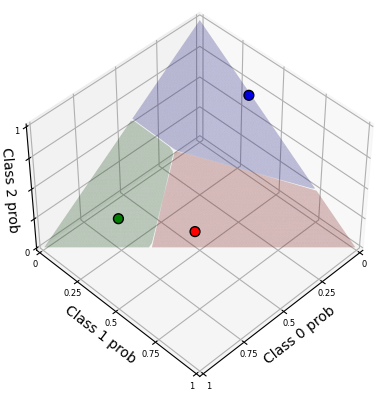

In [18]:
ax = plt.figure().add_subplot(projection='3d')

config_ax(ax)
ax.scatter(centroides_candidates[:, 0], centroides_candidates[:, 1], zs=centroides_candidates[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
plot_3d_regions(nn_candidates, ax)
plt.show()

A estratégia que seguirá é motivada nessas novas regiões que podemos construir.

Como esses três centroídes (ou de forma genérica `n` pontos) de dimensão três (ou `n`) definem como iremos quebramos o simplex em três (ou `n`) regiões diferentes, iremos fazer uma [busca aleatória](https://en.wikipedia.org/wiki/Random_search) para encontrar a posição desses centroídes a fim de maximizar uma métrica de interesse. Isso é totalmente análogo à estratégia do caso binário, com a diferença que definir um grid nesse caso é muito mais difícil.

## Ajustando o sampling de candidatos a centroídes

Nem sempre o sampling aleatório irá nos retornar pontos de centroíde que estou definindo como válidos. Por exemplo, o sampling anterior é tal que a quina `(1, 0, 0)` agora estaria sendo classificada como sendo da classe 2 uma vez que está na região de influencia do ponto verde.

Isso é fácil de resolver apenas fazendo uma permutação da posição dos centroídes de forma que as quinas estejam sempre associadas com o centroíde de indice correto, ou seja, o indice do centroíde mais próximo de `(1, 0, 0)` precisa ser `0` e assim por diante.

O outro problema é um pouco mais chato. Dependendo da amostragem em cima do simplex, um centroíde pode ser o ponto mais perto de duas diferentes quinas. Esse caso é patológico demais e parece ser perda de tempo calcular as métricas para esse tipo de `predict` e, por isso, quando um sample assim acontece, apenas refazemos ele.

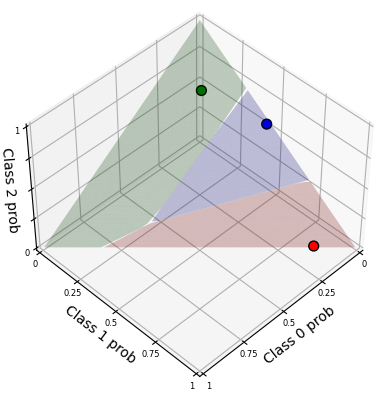

In [19]:
centroides_candidates = runif_in_simplex(3, random_state=11)

nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroides_candidates)

ax = plt.figure().add_subplot(projection='3d')

config_ax(ax)
ax.scatter(centroides_candidates[:, 0], centroides_candidates[:, 1], zs=centroides_candidates[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
plot_3d_regions(nn_candidates, ax)
plt.show()

Essa lógica de reordenação e reamostragem em casos patológicos está implementada na função `sample_valid_point`.

In [20]:
def sample_valid_point(n, random_state=None):
    sample = runif_in_simplex(n, random_state=random_state)
    edges = np.identity(n)
    nn_sample = NearestNeighbors(n_neighbors=1, p=2).fit(sample)
    _, ind_edges = nn_sample.kneighbors(edges)
    
    if len(np.unique(ind_edges[:, 0])) == n:
        return sample[ind_edges[:, 0]] # ordena do jeito certo
    else:
        new_random_state = np.random.RandomState(random_state).randint(0, 2**32 - 1, dtype=np.int64)
        return sample_valid_point(n, random_state=new_random_state)

In [21]:
from sklearn.metrics import matthews_corrcoef

macro < micro rs 
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [22]:
metric_list = []

for i in tqdm(range(10000)):
    centroides = sample_valid_point(3, random_state=i)
    nn_centroides = NearestNeighbors(n_neighbors=1, p=2).fit(centroides)
    _, new_preds = nn_centroides.kneighbors(probs)
    metric_list.append(matthews_corrcoef(y_train_threshold, new_preds[:, 0]))

100%|██████████| 10000/10000 [04:04<00:00, 40.94it/s]


In [23]:
best_random_state = np.argmax(metric_list)

In [29]:
centroides = sample_valid_point(3, random_state=best_random_state)
nn_centroides = NearestNeighbors(n_neighbors=1, p=2).fit(centroides)

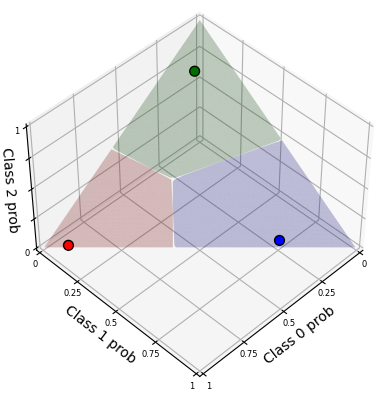

In [30]:
ax = plt.figure().add_subplot(projection='3d')

config_ax(ax)
ax.scatter(centroides[:, 0], centroides[:, 1], zs=centroides[:, 2], c=['r', 'b', 'g'], s=50, edgecolor='k', alpha=1)
plot_3d_regions(nn_centroides, ax)
plt.show()

In [31]:
_, new_preds = nn_centroides.kneighbors(model.predict_proba(X_test))
old_preds = model.predict(X_test)

matthews_corrcoef(y_test, old_preds), matthews_corrcoef(y_test, new_preds[:, 0])

(0.22384931642747133, 0.23929509488870107)

Da pra fazer algo tipo bayes search prob.

___

discuto outras métricas? ...

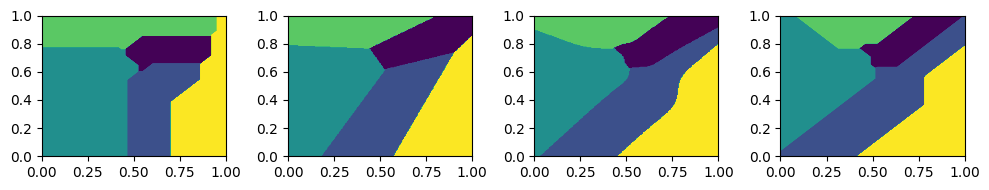

In [27]:
centros = np.random.RandomState(0).uniform(0, 1, size=(5, 2))
x=np.linspace(0, 1, 201)
y=np.linspace(0, 1, 201)
 
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(ncols=4, figsize=(10, 2))

for i, p in enumerate([1, 2, 4, 50]):
    nn = NearestNeighbors(n_neighbors=1, p=p).fit(centros)

    _, ind = nn.kneighbors(np.vstack([np.ravel(X), np.ravel(Y)]).T)
    Z = ind.reshape(X.shape)

    ax[i].contourf(X, Y, Z, 100)

plt.tight_layout()

___